# TP 2: Expectation-Maximisation algorithm – Importance sampling


In [1]:
# Imports

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse
import matplotlib.colors as mcol
import matplotlib.cm as cm
import pandas as pd


EPS = 1e-6

In [2]:
# Useful functions for later

n_ellipses = 6
cmap = mcol.LinearSegmentedColormap.from_list("custom_cmap", ["#990505", "#f5baba"])
cnorm = mcol.Normalize(vmin=1, vmax=n_ellipses)
cpick = cm.ScalarMappable(norm=cnorm, cmap=cmap)
cpick.set_array([])


def draw_ellipse(position, covariance, ax=None):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    if covariance.shape == (2, 2):
        U, s, _ = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    for nsig in range(1, n_ellipses + 1):
        ax.add_patch(
            Ellipse(
                position,
                (2 / n_ellipses) * nsig * width,
                (2 / n_ellipses) * nsig * height,
                angle=angle,
                alpha=1,
                linewidth=1,
                edgecolor=cpick.to_rgba(nsig),
                fill=False,
            )
        )


def draw_gmm(ax, x, y, mu, sigma, nb_classes):
    ax.scatter(x, y, s=40, facecolors="none", edgecolors="#4d76c4")
    for classe in range(nb_classes):
        draw_ellipse((mu[classe, 0], mu[classe, 1]), sigma[classe, :, :], ax=ax)

## Exercice 1 :

### Question 2)

In [3]:
number_of_points = 10
x = np.arange(number_of_points)
p = np.random.rand(number_of_points)
p /= p.sum()


def sim(p, X):
    cum_probas = p.cumsum()
    u = np.random.rand()
    index = (cum_probas > u).argmax()
    return X[index]

### Question 3)

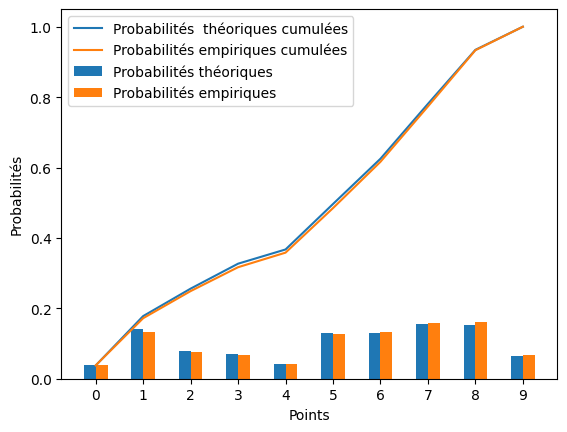

In [4]:
histogram = np.array([0 for _ in range(number_of_points)])
N = 10000
for _ in range(N):
    histogram[sim(p, x)] += 1

histogram = histogram / N

width = 0.25
plt.bar(x - width / 2, p, width=width, label="Probabilités théoriques")
plt.bar(x + width / 2, histogram, width=width, label="Probabilités empiriques")
plt.plot(x, p.cumsum(), label="Probabilités  théoriques cumulées")
plt.plot(x, histogram.cumsum(), label="Probabilités empiriques cumulées")
plt.xlabel("Points")
plt.xticks(x)
plt.ylabel("Probabilités")
plt.legend()
plt.show()

## Exercice 2 :

### Question 2)

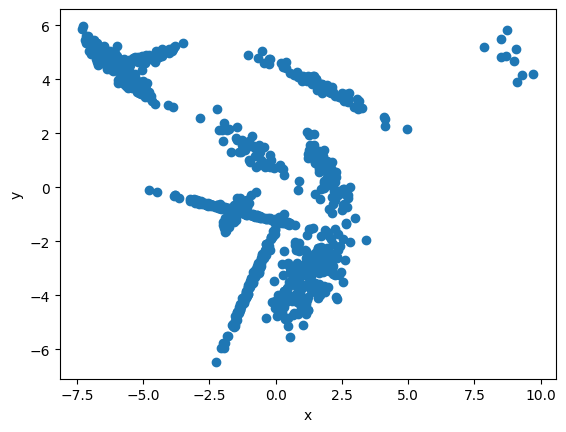

In [5]:
def init(nb_classes, d=2):
    mu = 4 * np.random.randn(nb_classes, d)
    sigma = np.random.randn(nb_classes, d, d) * 0.6
    sigma = sigma @ sigma.transpose(0, 2, 1)
    alpha = np.random.rand(nb_classes)
    alpha = alpha / np.sum(alpha)
    return mu, sigma, alpha


def simulate_gmm(mu, sigma, alpha, nb=1):
    if nb == 1:
        classe = np.random.choice(len(alpha), p=alpha)

        return np.random.multivariate_normal(mu[classe], sigma[classe])

    classe = np.random.choice(len(alpha), size=nb, replace=True, p=alpha)
    x = []
    for i in range(len(alpha)):
        nb_draws = np.sum(classe == i)
        x.append(np.random.multivariate_normal(mu[i], sigma[i], size=nb_draws))
    return np.concatenate(x)


nb_classes = 10
N = 1000

mu, sigma, alpha = init(nb_classes)
x = []
y = []
for _ in range(N):
    x_sim, y_sim = simulate_gmm(mu, sigma, alpha)
    x.append(x_sim)
    y.append(y_sim)

plt.scatter(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Question 3)

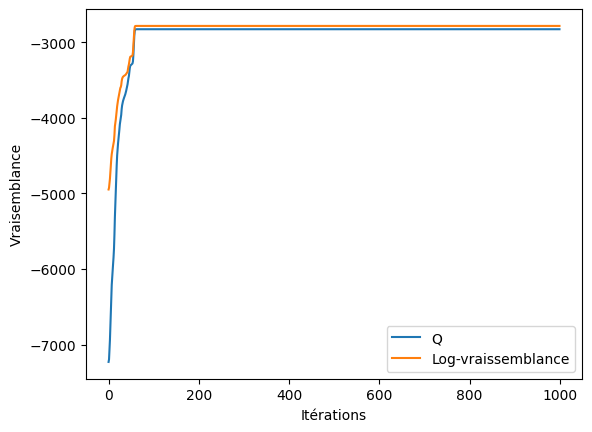

In [6]:
def m_step(x, z):
    alpha = np.sum(z, axis=0) / np.sum(z, axis=(0, 1))
    mu = np.einsum("ij, id -> jd", z, x) / np.sum(z, axis=0)[:, None]
    sigma = (
        np.einsum(
            "ij, jik, jil -> jkl", z, x[None, :] - mu[:, None], x[None, :] - mu[:, None]
        )
        / np.sum(z, axis=0)[:, None, None]
    )
    return alpha, mu, sigma


def e_step(x, alpha, mu, sigma, verbose=True):
    p = len(alpha)
    n = len(x)
    f = np.zeros((p, n))
    for j in range(p):
        gaussian = multivariate_normal(mu[j], sigma[j] + EPS * np.eye(len(mu[j])))
        f[j, :] = gaussian.pdf(x)
    z = np.transpose(alpha[:, None] * f / np.einsum("j, ji -> i", alpha, f)[None, :])
    if verbose:
        Q = np.transpose(np.log(f + EPS) + np.log(alpha + EPS)[:, None])
        Q = np.sum(Q * z, axis=(0, 1))
        return z, Q
    return z


def log_likelihood(x, alpha, mu, sigma):
    p = len(alpha)
    n = len(x)
    f = np.zeros((p, n))
    for j in range(p):
        gaussian = multivariate_normal(mu[j], sigma[j] + EPS * np.eye(len(mu[j])))
        f[j, :] = gaussian.pdf(x)
    return np.sum(np.log(np.einsum("j, ji -> i", alpha, f)))


def em(x, p, iterations=1000, verbose=True):
    n = len(x)
    z = np.random.rand(n, p)
    z = z / np.sum(z, axis=1)[:, np.newaxis]

    Q_values = []
    ll_values = []

    for k in range(iterations):
        alpha, mu, sigma = m_step(x, z)
        if verbose:
            z, Q = e_step(x, alpha, mu, sigma)
            Q_values.append(Q)
            ll = log_likelihood(x, alpha, mu, sigma)
            ll_values.append(ll)
            print(
                f"Iteration {k+1}/{iterations} | Q={Q} | ll={ll}",
                "                    ",
                end="\r",
            )
        else:
            z = e_step(x, alpha, mu, sigma, verbose=False)

    return alpha, mu, sigma, z, Q_values, ll_values


alpha_estimator, mu_estimator, sigma_estimator, z, Q, ll = em(
    np.array([x, y]).transpose(), nb_classes
)

plt.plot(Q, label="Q")
plt.plot(ll, label="Log-vraissemblance")
plt.xlabel("Itérations")
plt.ylabel("Vraisemblance")
plt.legend()
plt.show()

On note que $Q$ est bien une borne inférieure de la log-vraisemblance.

### Question 4)

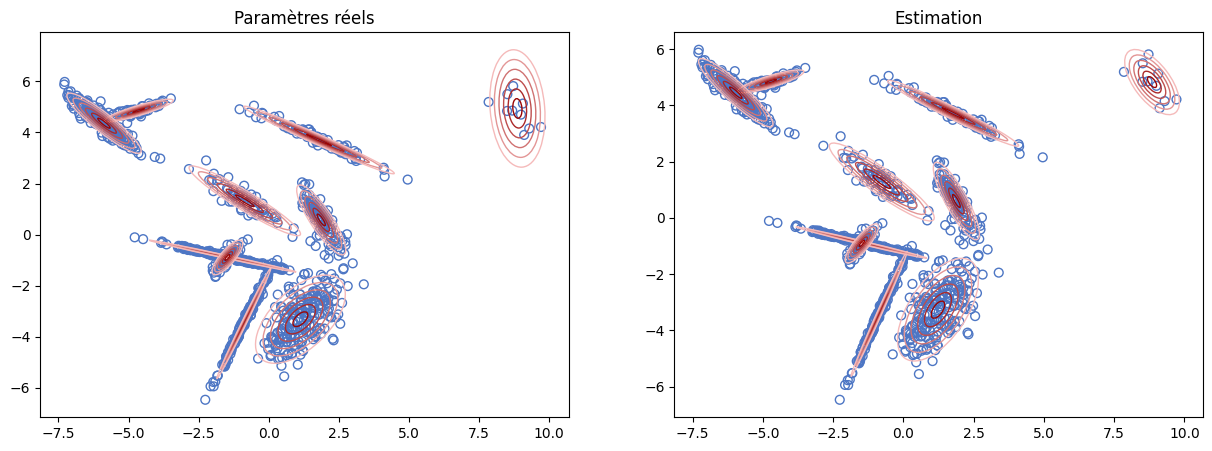

In [7]:
# Plot the results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

draw_gmm(ax[0], x, y, mu, sigma, nb_classes)
ax[0].set_title("Paramètres réels")

draw_gmm(ax[1], x, y, mu_estimator, sigma_estimator, nb_classes)
ax[1].set_title("Estimation")

plt.show()

Les paramètres estimés sont proches de ceux réels pour la plupart des clusters. Cependant un cluster peu représenté peut être mal estimé. On a aussi plus d'erreurs quand les clusters se superposent.

### Question 5)

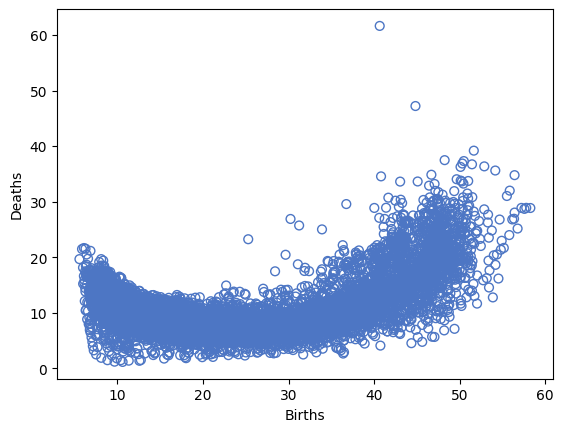

In [8]:
file = "WPP2019_Period_Indicators_Medium.csv"
df = pd.read_csv(file, sep=",")
df = df[["CBR", "CDR"]].dropna()
x = df.to_numpy()

plt.scatter(x[:, 0], x[:, 1], s=40, facecolors="none", edgecolors="#4d76c4")
plt.xlabel("Births")
plt.ylabel("Deaths")
plt.show()

Il n'est pas évident qu'un mélange de gaussiennes soit pertinent dans ce cas.

### Question 6)

Combien a-t-on de degrés de liberté pour le modèle à $p$ classes ?
* Pour $\alpha$, on a $p-1$ degrés de liberté (car $\sum_{i=1}^p \alpha_i = 1$).
* Pour $\mu$, on a $p \times d$ degrés de liberté.
* Pour $\Sigma$, on a $p \times d$ degrés de liberté (car $\Sigma$ est définie positive donc on peut la caractériser par ses $d$ valeurs propres).

Au total on a $p-1 + 2p \times d$ degrés de liberté.

In [9]:
def BIC(x, alpha, mu, sigma):
    p = len(alpha)
    d = len(mu[0])
    n = len(x)
    return -log_likelihood(x, alpha, mu, sigma) + (2 * p * d + p - 1) / 2 * np.log(n)

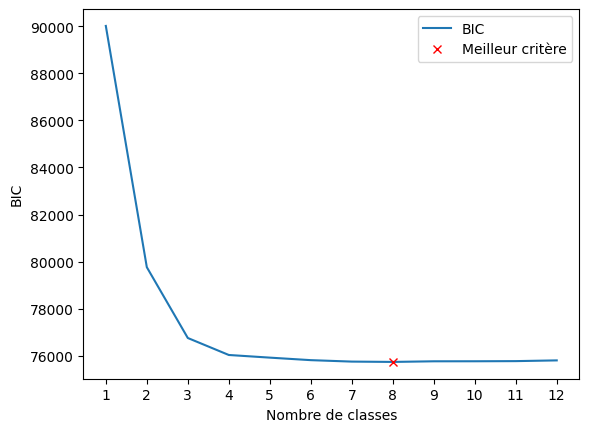

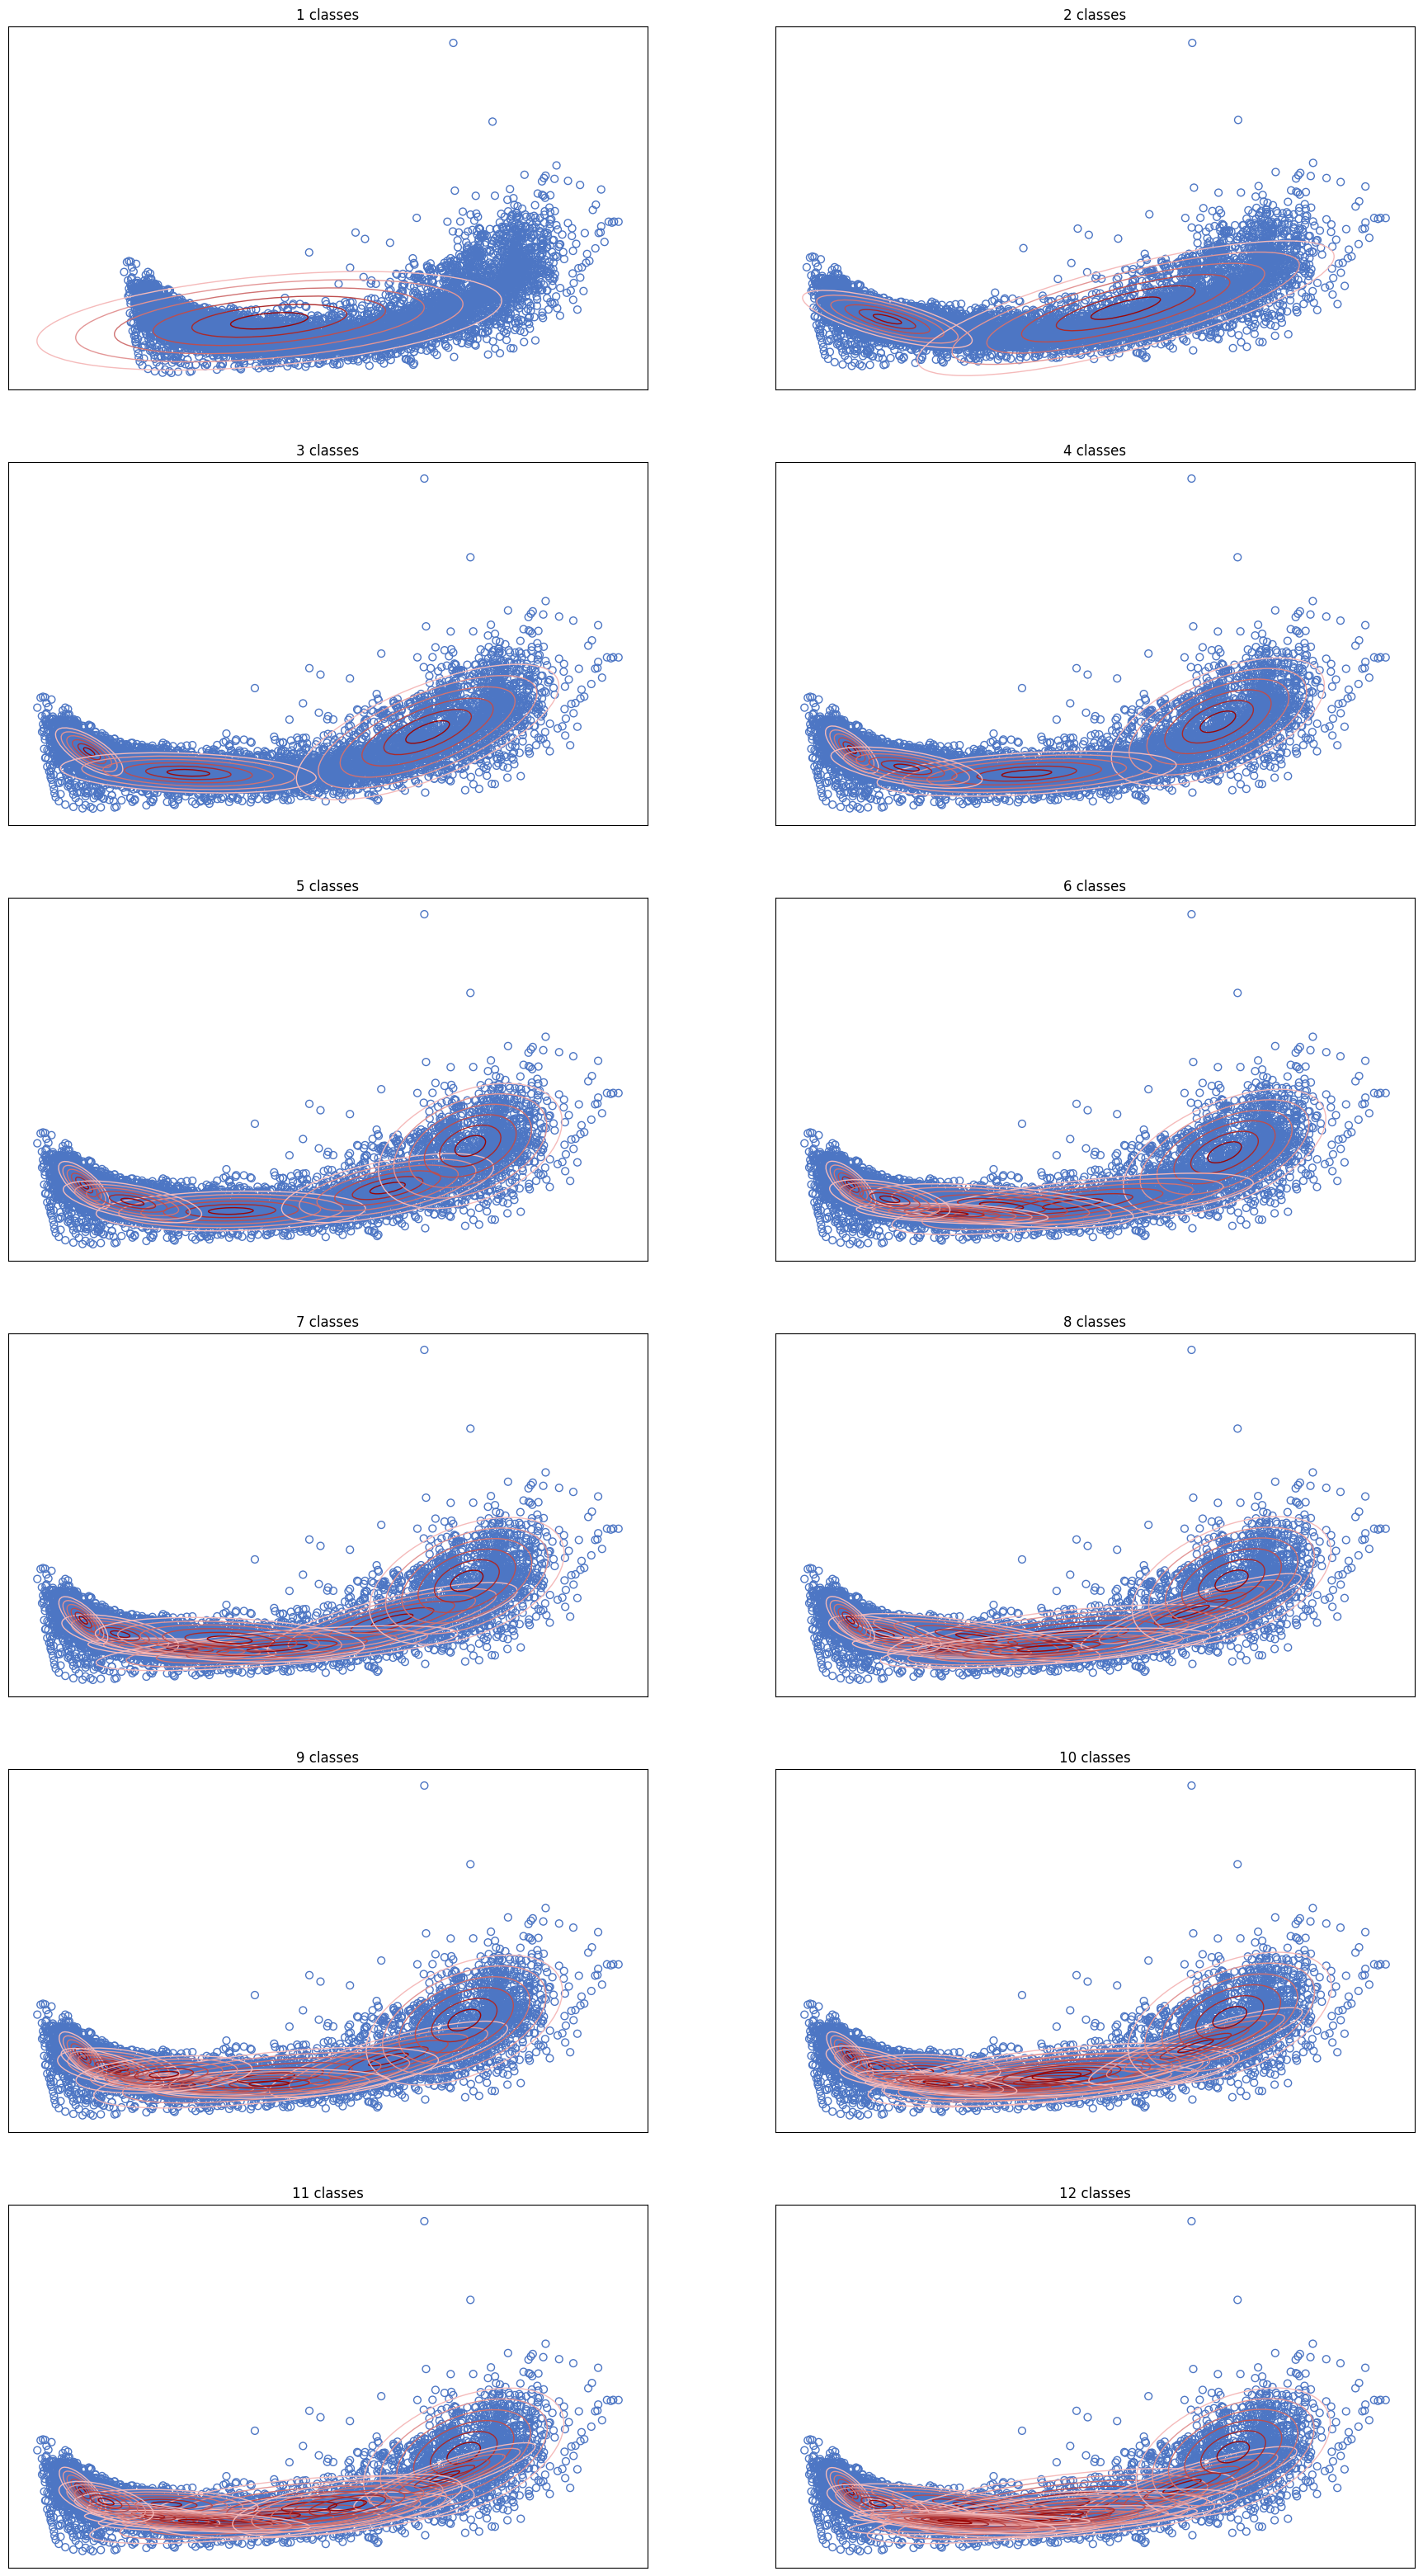

In [10]:
max_nb_classes = 12
m = np.arange(1, max_nb_classes + 1, 1)
bics = []
alphas = []
mus = []
sigmas = []

for i in m:
    print("Running EM with", i, "classes...", end="\r")
    alpha_estimator, mu_estimator, sigma_estimator, z, _, _ = em(
        x, i, iterations=100, verbose=False
    )
    bics.append(BIC(x, alpha_estimator, mu_estimator, sigma_estimator))
    alphas.append(alpha_estimator)
    mus.append(mu_estimator)
    sigmas.append(sigma_estimator)

best_nb_classes = np.argmin(bics) + 1
plt.plot(m, bics, label="BIC")
plt.plot(
    best_nb_classes,
    bics[best_nb_classes - 1],
    "x",
    color="red",
    label="Meilleur critère",
)
plt.xlabel("Nombre de classes")
plt.ylabel("BIC")
plt.xticks(m)
plt.legend()
plt.show()

split = 2
fig, ax = plt.subplots(max_nb_classes // split, split, figsize=(22, 40))
for k, (nb_classes, mu, sigma) in enumerate(zip(m, mus, sigmas)):
    draw_gmm(ax[k // split, k % split], x[:, 0], x[:, 1], mu, sigma, nb_classes)
    ax[k // split, k % split].set_title(f"{nb_classes} classes")
    ax[k // split, k % split].set_xticks([])
    ax[k // split, k % split].set_yticks([])

Comme on s'y attendait on n'a pas des résultats transcendants. Certes nos gaussiennes recouvrent bien les données mais on ne peut pas vraiment parler de clustering. C'est un assemblage de gaussiennes qui ne nous apprend pas grand chose sur la structure des données.

## Exercice 3 :

### Question 1)

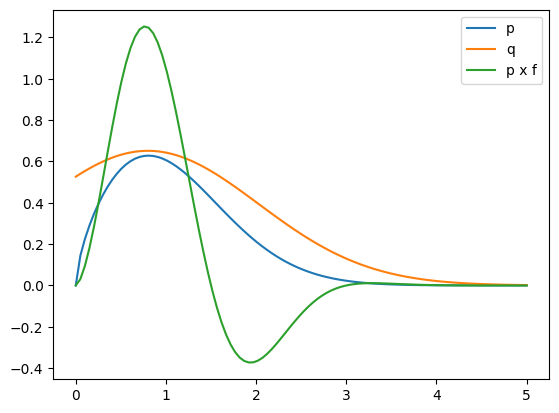

In [11]:
def f(x):
    return (x > 0) * 2 * np.sin(x * 2 * np.pi / 3)


def p(x):
    return x**0.65 * np.exp(-(x**2) / 2) * (x > 0)


def q(x, mu=None):
    if mu is None:
        mu = 0.8
    return 2 / (np.sqrt(2 * np.pi * 1.5)) * np.exp(-((mu - x) ** 2) / (2 * 1.5))


x = np.linspace(0, 5, 100)
plt.plot(x, p(x), label="p")
plt.plot(x, q(x), label="q")
plt.plot(x, p(x) * f(x), label="p x f")
plt.legend()
plt.show()

In [12]:
def simple_importance_sampling(n, mu=None):
    samples = []
    count = 0
    while count < n:
        x = np.random.normal(0.8, 1.5)
        if x < 0:
            continue
        samples.append(x)
        count += 1
    samples = np.array(samples)
    importance_weights = p(samples) / q(samples, mu=mu)
    monte_carlo_values = f(samples) * importance_weights
    return np.mean(monte_carlo_values), np.var(monte_carlo_values), importance_weights

### Question 2)

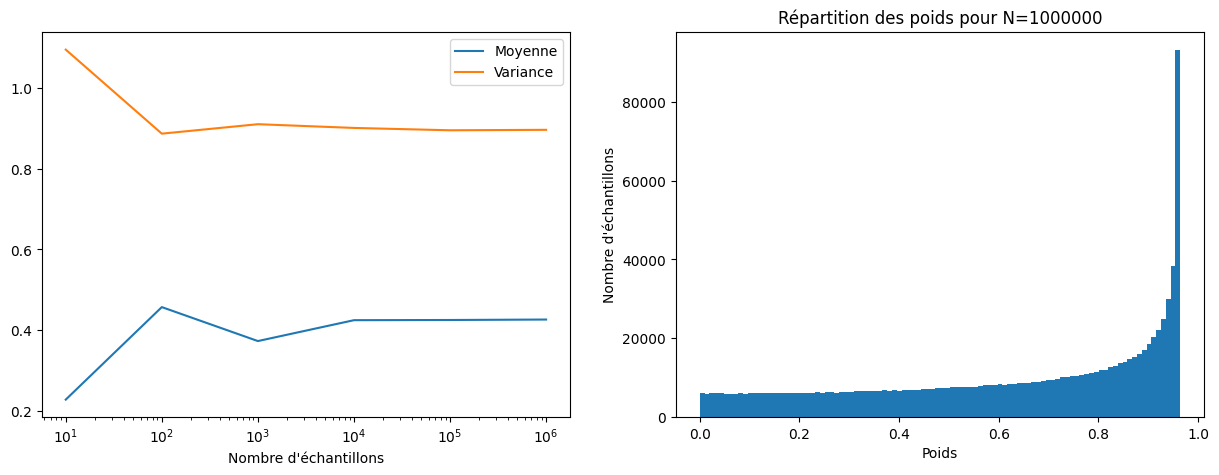

In [13]:
N = [10, 100, 1000, 10000, 100000, 1000000]

means, variances = [], []

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for n in N:
    mean, variance, importance_weights = simple_importance_sampling(n)
    means.append(mean)
    variances.append(variance)

ax[0].plot(N, means, label="Moyenne")
ax[0].plot(N, variances, label="Variance")
ax[0].set_xlabel("Nombre d'échantillons")
ax[0].legend()
ax[0].set_xscale("log")

ax[1].hist(importance_weights, bins=100)
ax[1].set_title(f"Répartition des poids pour N={N[-1]}")
ax[1].set_xlabel("Poids")
ax[1].set_ylabel("Nombre d'échantillons")

plt.show()

### Question 3)

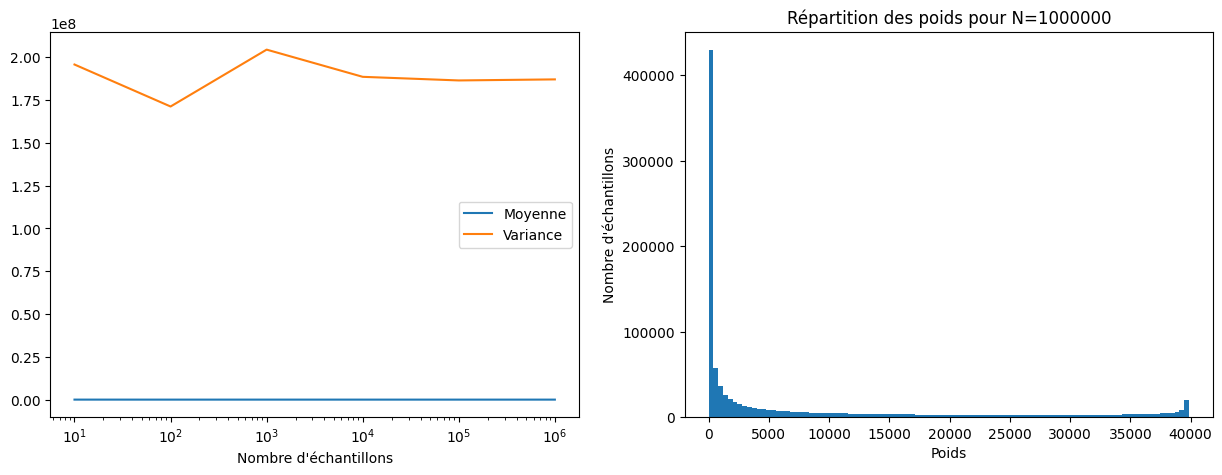

In [14]:
means, variances = [], []

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for n in N:
    mean, variance, importance_weights = simple_importance_sampling(n, mu=6)
    means.append(mean)
    variances.append(variance)

ax[0].plot(N, means, label="Moyenne")
ax[0].plot(N, variances, label="Variance")
ax[0].set_xlabel("Nombre d'échantillons")
ax[0].legend()
ax[0].set_xscale("log")

ax[1].hist(importance_weights, bins=100)
ax[1].set_title(f"Répartition des poids pour N={N[-1]}")
ax[1].set_xlabel("Poids")
ax[1].set_ylabel("Nombre d'échantillons")

plt.show()

Quand les centres de masse de $p$ et $q$ sont éloignés, $p$ va valoir $0$ sur une grande partie de l'espace. Quand on est en bout de distribution de $q$ ($p$ n'est plus nul mais $q$ s'approche de $0$), on a un grand poids d'importance pour un petit nombre de points. Cela peut être problématique pour la procédure d'estimation.

### Question 5)

In [15]:
def banana_pdf(x, d, sigma_squarred, b):
    sigma = np.eye(d)
    sigma[0, 0] = sigma_squarred
    mu = np.zeros(d)
    x[:, 1] = x[:, 1] + b * (x[:, 0] ** 2 - sigma_squarred)
    return multivariate_normal(mu, sigma).pdf(x)


d = 5
sigma_squarred = 1
b = 0.4

In [16]:
def m_step(x, z, importance_weights):
    zw = z * importance_weights[:, None] + EPS
    alpha = np.sum(zw, axis=0) / np.sum(zw, axis=(0, 1))
    mu = np.einsum("ij, id -> jd", zw, x) / np.sum(zw, axis=0)[:, None]
    sigma = (
        np.einsum(
            "ij, jik, jil -> jkl",
            zw,
            x[None, :] - mu[:, None],
            x[None, :] - mu[:, None],
        )
        / np.sum(zw, axis=0)[:, None, None]
    )
    return alpha, mu, sigma


def e_step(x, alpha, mu, sigma):
    p = len(alpha)
    n = len(x)
    f = np.zeros((p, n))
    for j in range(p):
        gaussian = multivariate_normal(mu[j], sigma[j] + EPS * np.eye(len(mu[j])))
        f[j, :] = gaussian.pdf(x)
    f = f + EPS
    z = np.transpose(alpha[:, None] * f / np.einsum("j, ji -> i", alpha, f)[None, :])
    return z


def mcp(K, d, sigma_squarred, b, n=100, iterations=100):
    mu, sigma, alpha = init(K, d=d)
    for k in range(iterations):
        # (ii)
        # sample
        x = simulate_gmm(mu, sigma, alpha, nb=n)
        # estimate
        q = np.zeros((n))
        for i in range(K):
            q += alpha[i] * multivariate_normal(mu[i], sigma[i] + EPS * np.eye(d)).pdf(
                x
            )
        q += EPS
        importance_weights = banana_pdf(x, d, sigma_squarred, b) / q
        importance_weights /= np.sum(importance_weights)
        estimate = np.sum(importance_weights * np.log(q))

        # (iii)
        z = e_step(x, alpha, mu, sigma)
        alpha, mu, sigma = m_step(x, z, importance_weights)

        print(
            f"Iteration {k+1}/{iterations} | estimate={estimate}",
            "                    ",
            end="\r",
        )
    return estimate, alpha, mu, sigma

In [17]:
K = 5
estimate, alpha, mu, sigma = mcp(K, d, sigma_squarred, b, n=1000, iterations=1000)
print(alpha)

[0.18825204 0.24159875 0.18928941 0.19012725 0.19073256]              


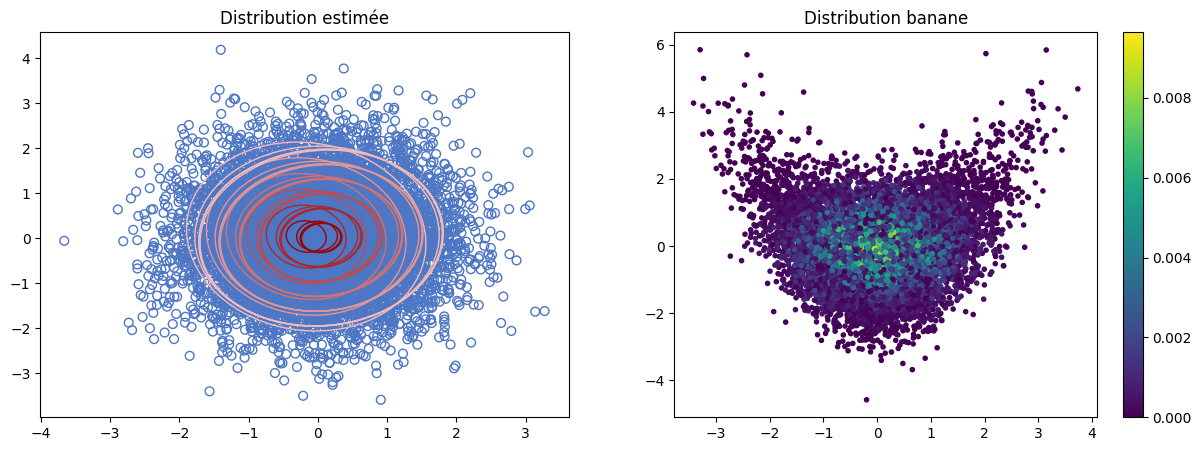

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
N = 10000

# Estimation
x = []
for _ in range(N):
    x.append(simulate_gmm(mu, sigma, alpha))
x = np.array(x)
draw_gmm(ax[0], x[:, 0], x[:, 1], mu[:, :2], sigma[:, :2, :2], K)
ax[0].set_title("Distribution estimée")

# Densité réelle
points = np.random.randn(N, d)
pdf_values = banana_pdf(points, d, sigma_squarred, b)
scatter = ax[1].scatter(
    points[:, 0], points[:, 1], c=pdf_values, cmap="viridis", marker="."
)
ax[1].set_title("Distribution banane")
fig.colorbar(scatter, ax=ax[1])

plt.show()

On n'arrive pas à retrouver une distribution banane. Il est clair que les gaussiennes commencent à prendre la forme de la banane mais il faudrait qu'elles soient plus étirées dans la direction de la banane. Il est possible que nos poids d'importance ne soient pas bons.